<a href="https://colab.research.google.com/github/antonio-florian/AnalizaSesizariBe/blob/main/PneumonieCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(tf.__version__)

Number of replicas: 1
Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
2.19.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = path
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [ ]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person731_bacteria_2633.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person431_virus_880.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person462_bacteria_1967.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person23_bacteria_91.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person500_bacteria_2110.jpeg'


In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [ ]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [ ]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

np.int64(624)

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

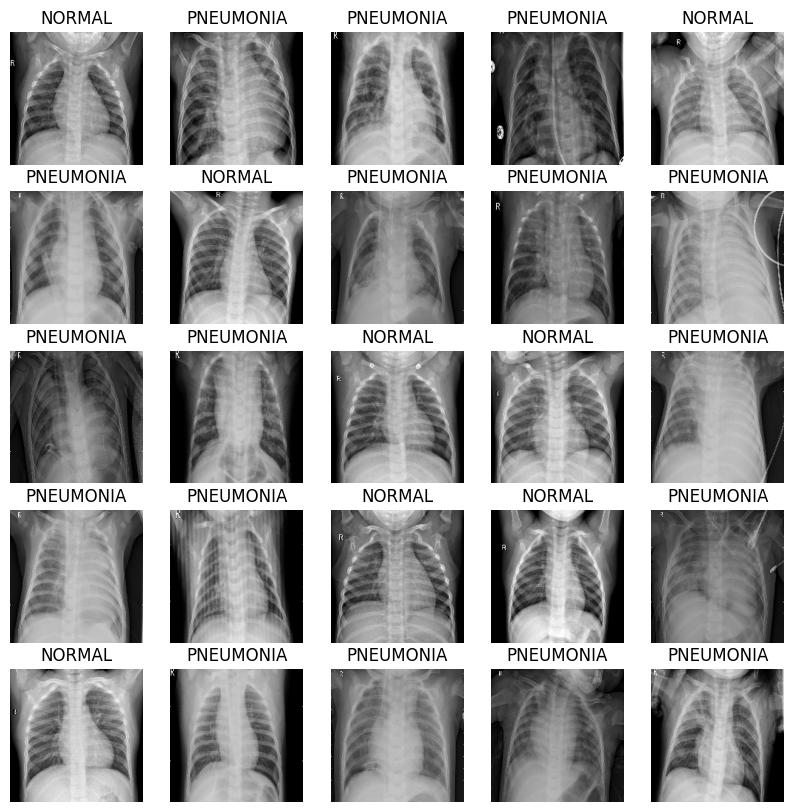

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.05106674])

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 98s 335ms/step - accuracy: 0.7193 - loss: 0.5244 - precision: 0.9130 - recall: 0.6916 - val_accuracy: 0.7454 - val_loss: 0.5682 - val_precision: 0.7454 - val_recall: 1.0000
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8942 - loss: 0.2497 - precision: 0.9778 - recall: 0.8812 - val_accuracy: 0.7463 - val_loss: 0.8092 - val_precision: 0.7463 - val_recall: 1.0000
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9333 - loss: 0.1880 - precision: 0.9776 - recall: 0.9322 - val_accuracy: 0.7463 - val_loss: 1.2949 - val_precision: 0.7463 - val_recall: 1.0000
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9361 - loss: 0.1744 - precision: 0.9800 - recall: 0.9334 - val_accuracy: 0.7483 - val_loss: 0.9520 - val_precision: 0.7483 - val_recall: 1.0000
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9481 - loss: 0.1481 - precision: 0.9825 - recall: 0.9478 - val_accuracy: 0.9746 - val_l

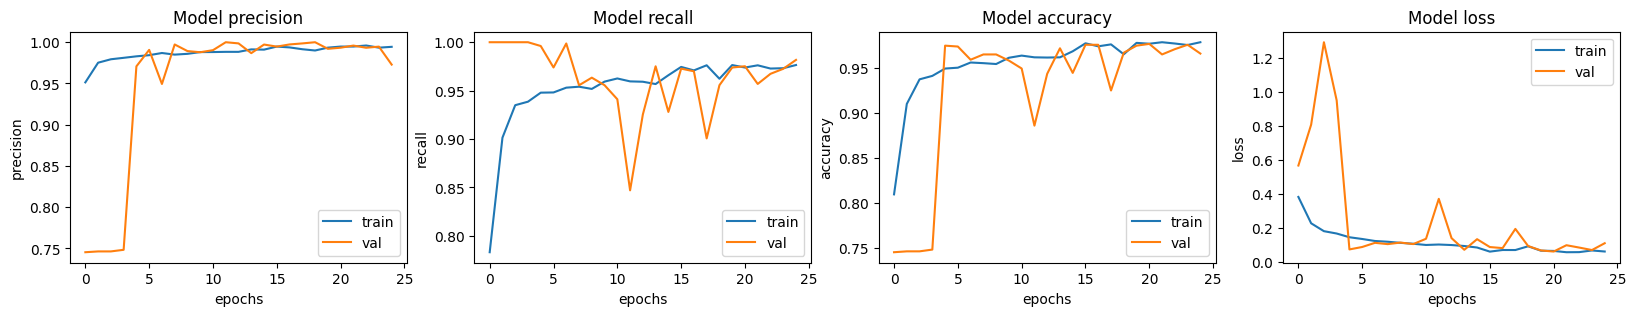

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
def get_img_and_preprocess(image_path, img_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if tf.reduce_max(preds) > 0.5:
            # If probability of class 1 (Pneumonia) is high, get gradient for class 1
            pred_index = 1
        else:
            # Otherwise, get gradient for class 0 (Normal)
            pred_index = 0
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(image_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.jet

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [ ]:
import tensorflow as tf
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
GCS_PATH = path

test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
sample_image_path_bytes = next(iter(test_list_ds.take(1)))
sample_image_path = sample_image_path_bytes.numpy().decode('utf-8')

print(f"Sample image path: {sample_image_path}")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Sample image path: /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person15_virus_46.jpeg


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Re-initialize strategy for model compilation
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# Define constants needed for model and class weights
IMAGE_SIZE = [180, 180]

# Re-process data to get counts for class weights
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Calculate initial_bias and class_weight
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

# Instantiate and compile the model
with strategy.scope():
    model = build_model()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# Display model summary
model.summary()

Number of replicas: 1


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 45, 45, 32)     │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 22, 22, 64)     │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 11, 11, 128)    │        27,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 5, 5, 256)      │       103,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 512)            │     3,279,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,496,801 (13.34 MB)

 Trainable params: 3,494,433 (13.33 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if tf.reduce_max(preds) > 0.5:
            # If probability of class 1 (Pneumonia) is high, get gradient for class 1
            pred_index = 1
        else:
            # Otherwise, get gradient for class 0 (Normal)
            pred_index = 0
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.get_layer('dense_3').output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if tf.reduce_max(preds) > 0.5:
            # If probability of class 1 (Pneumonia) is high, get gradient for class 1
            pred_index = 1
        else:
            # Otherwise, get gradient for class 0 (Normal)
            pred_index = 0
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        inputs=model.inputs[0],
        outputs=[model.get_layer(last_conv_layer_name).output, model.get_layer('dense_7').output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # For a sigmoid output (binary classification), preds is a single probability.
        # If preds[0,0] > 0.5, it's Pneumonia (class 1), else Normal (class 0).
        if preds[0,0] > 0.5:
            # Get gradient for class 1 (Pneumonia) probability
            class_channel = preds[:, 0]
        else:
            # Get gradient for class 0 (Normal) probability (1 - Pneumonia probability)
            class_channel = 1 - preds[:, 0]


    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import matplotlib.pyplot as plt

def display_gradcam(image_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.jet

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

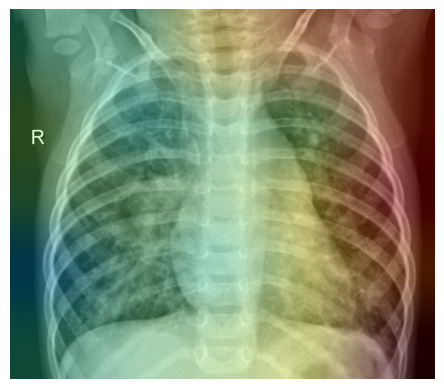

Grad-CAM visualization for image: /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person15_virus_46.jpeg


In [ ]:
last_conv_layer_name = 'sequential_11'

# Preprocess the sample image
img_array = get_img_and_preprocess(sample_image_path, IMAGE_SIZE)


_ = model(img_array)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display Grad-CAM
display_gradcam(sample_image_path, heatmap)

print(f"Grad-CAM visualization for image: {sample_image_path}")